# Gridding Operations

In [24]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import h5py
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import scipy.interpolate

In [25]:
fires = pd.read_csv('../data/VIIRSNDE_global2018312.v1.0.txt')
fires.head()

,Lon,Lat,Mask,Conf,brt_t13(K),frp(MW),line,sample,Sat,YearDay,Hour
0,27.110006,30.769241,8,52,302.877533,5.814295,242,1735,NDE,2018312,1
1,26.083252,30.534357,9,100,332.959717,24.340988,301,1620,NDE,2018312,1
2,34.865997,28.162659,8,38,301.165985,6.107953,396,2589,NDE,2018312,1
3,34.872623,28.161121,8,71,307.277985,9.287819,396,2590,NDE,2018312,1
4,34.865070,28.158880,8,39,301.227783,6.001442,402,2590,NDE,2018312,1


In [26]:
# Number of nx and ny points for the grid. 720 nx, 360 ny creates a 1.0 degree grid
coverage = [-180.0, -90.0, 180.0, 90.0]

grid_size = 1.0

num_points_x = int(coverage[2] - coverage[0] / grid_size)
num_points_y = int(coverage[3] - coverage[1] / grid_size)

print(num_points_x, num_points_y)

360 180


In [27]:
# Using a real step length will skip the end value (exclusive)
print(np.mgrid[0:4:1.0])

[0. 1. 2. 3.]


In [28]:
#Using a complex number of bins will include the end value (inclusvie)
print(np.mgrid[0:4:5j])

[0. 1. 2. 3. 4.]


In [29]:
nx = complex(0, num_points_x)
ny = complex(0, num_points_y)
Xnew, Ynew = np.mgrid[coverage[0]:coverage[2]:nx, coverage[1]:coverage[3]:ny]

In [30]:
fire_count = np.zeros([num_points_x, num_points_y])

for i, lon in enumerate(fires.Lon):
    lat = fires.Lat[i]
    
    adjlat = ((lat + 90) / grid_size)
    adjlon = ((lon + 180) / grid_size)
    latbin = int(adjlat) 
    lonbin = int(adjlon)
    
    fire_count[lonbin, latbin] = fire_count[lonbin, latbin] + 1 
    

In [31]:
fire_count[fire_count == 0] = np.nan

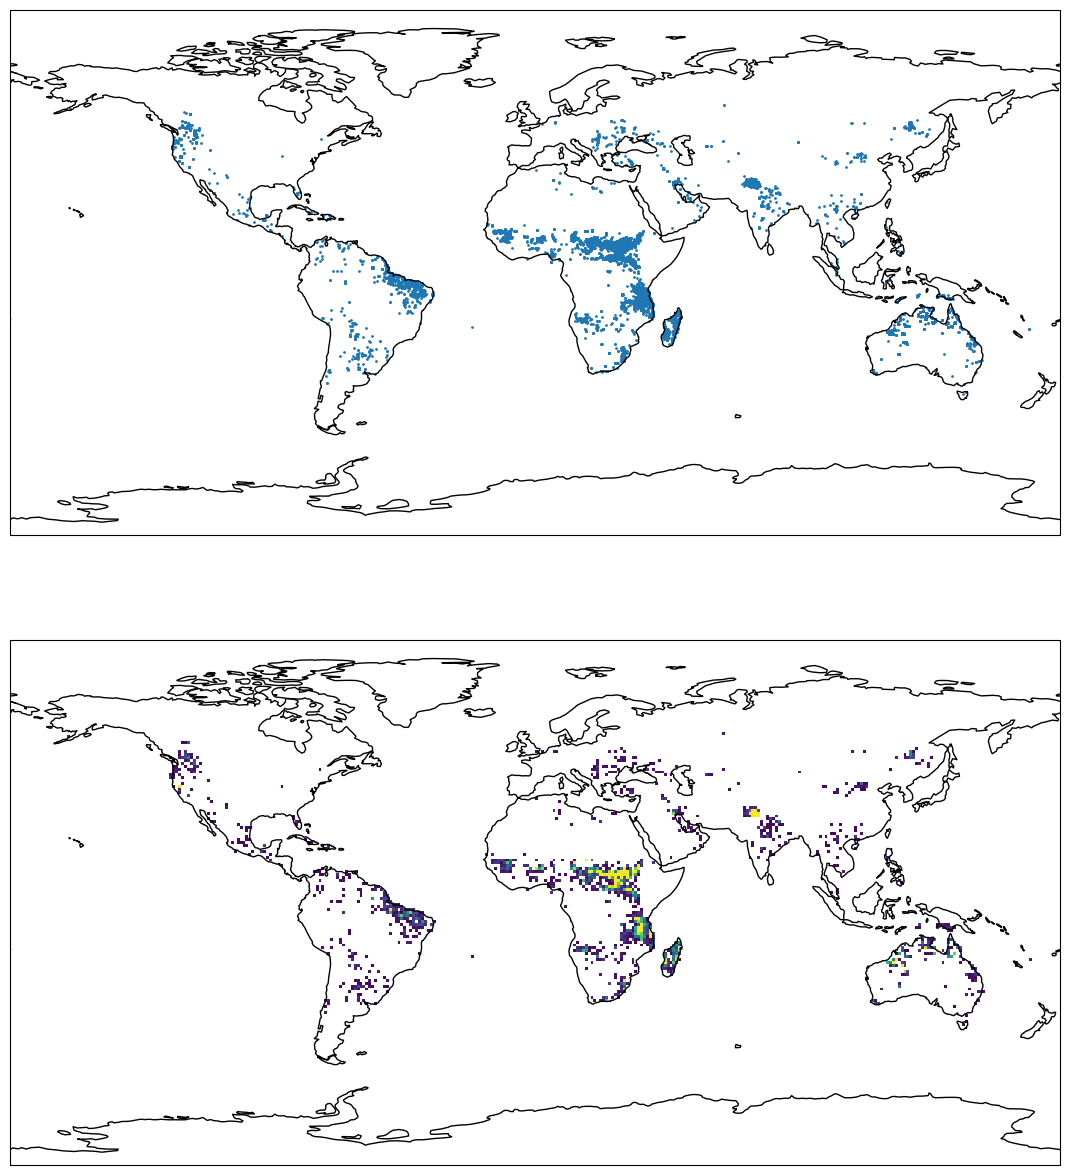

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[15,15], subplot_kw={'projection':ccrs.PlateCarree()})

ax1.coastlines()
ax1.set_global()

ax1.scatter(fires['Lon'], fires['Lat'], s=1)

ax2.coastlines()
ax2.set_global()

ax2.pcolormesh(Xnew, Ynew, fire_count, vmin=0, vmax=40)

plt.show()

In [33]:
fname = '../data/3B-HHR.MS.MRG.3IMERG.20160811-S233000-E235959.1410.V06B_thinned.HDF5'
imergv6 = h5py.File(fname, 'r')

In [34]:
precip = imergv6['Grid/precipitationCal'][0,:,:]
lat = imergv6['Grid/lat'][:]
lon = imergv6['Grid/lon'][:]

In [35]:
Xold, Yold = np.meshgrid(lon, lat, indexing='ij')

In [36]:
def create_2d_grid(grid_size):
    coverage = [-180.0, -90.0, 180.0, 90.0]
    
    num_points_x = int((coverage[2] - coverage[0]) / grid_size)
    num_points_y = int((coverage[3] - coverage[1]) / grid_size)
    
    nx = complex(0, num_points_x)
    ny = complex(0, num_points_y)
    
    Xnew, Ynew = np.mgrid[coverage[0]:coverage[2]:nx, coverage[1]:coverage[3]:ny]
    
    return Xnew, Ynew

In [37]:
Xnew, Ynew = create_2d_grid(0.5)

In [38]:
precip.shape, Yold.shape, Ynew.shape

((3600, 1800), (3600, 1800), (720, 360))

In [39]:
values = precip.flatten()

dims = (values.shape[0], 2)
points = np.zeros(dims)
points[:, 0] = Xold.flatten()
points[:, 1] = Yold.flatten()

In [40]:
gridOut = scipy.interpolate.griddata(points, values, (Xnew, Ynew), method='nearest')

/Users/justinreid/mambaforge/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


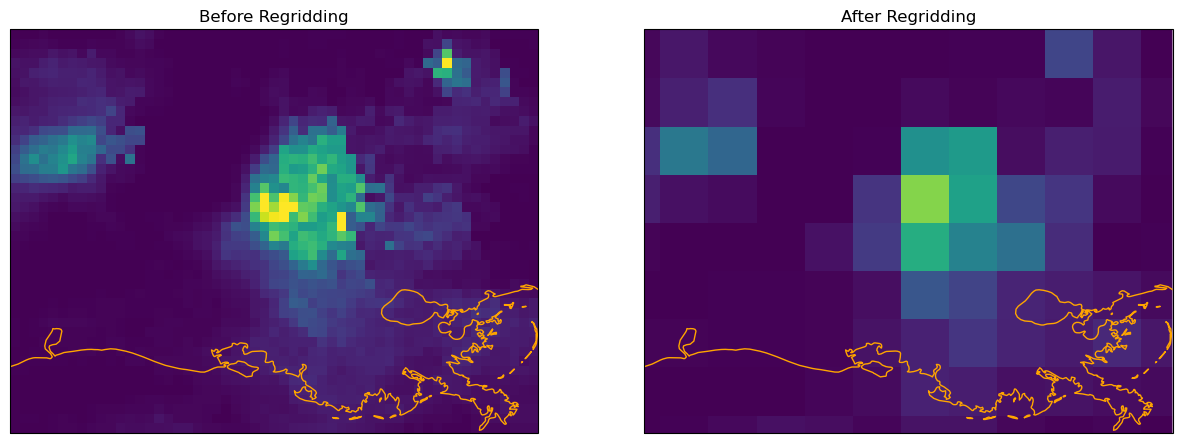

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=[15, 15], subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.set_extent([-94.3, -88.8, 28.9, 33.1])
    ax.coastlines('10m', color='orange')

axes[0].set_title('Before Regridding')
axes[0].pcolormesh(Xold, Yold, precip, vmin=0, vmax=20)

axes[1].set_title('After Regridding')
axes[1].pcolormesh(Xnew, Ynew, gridOut, vmin=0, vmax=20)

plt.show()

In [42]:
fname = '../data/goes-meso/michael/OR_ABI-L1b-RadM1-M3C02_G16_s20182822019282_e20182822019339_c20182822019374.nc'
g16nc = Dataset(fname, 'r')
C02 = g16nc.variables['Rad'][:][:]

In [43]:
proj_var = g16nc.variables['goes_imager_projection']
sat_height = proj_var.perspective_point_height
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis
central_lon = proj_var.longitude_of_projection_origin
globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)

In [44]:
# Multiply the x, y coordinates by satellite height to get the pixel position
X = g16nc.variables['x'][:] * sat_height
Y = g16nc.variables['y'][:] * sat_height
imgExtent = (X.min(), X.max(), Y.min(), Y.max())
crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)

In [45]:
resized_C02 = C02[::20, ::20]

/Users/justinreid/mambaforge/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


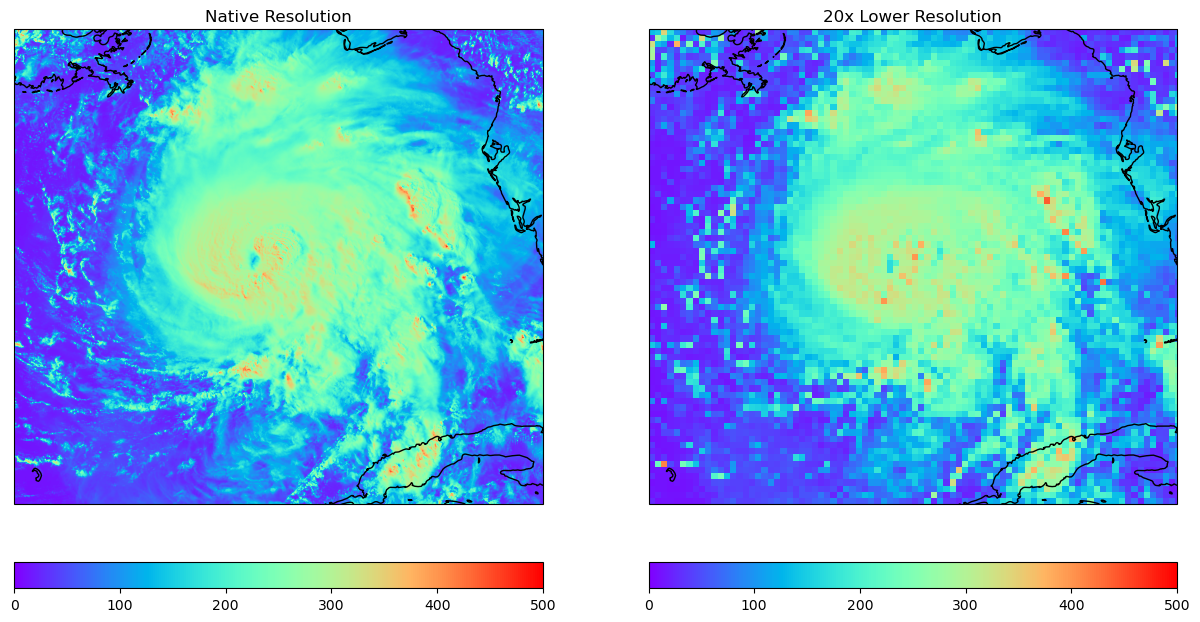

In [46]:
lims = [0, 500]
fig, axes = plt.subplots(ncols=2, figsize=[15, 15], subplot_kw={'projection': crs})

for ax in axes:
    ax.set_extent([-90.0, -82.0, 22.0, 30.0])
    ax.coastlines('10m', color='black')
    
axes[0].set_title('Native Resolution')
im1 = axes[0].imshow(
    C02, cmap=plt.get_cmap('rainbow'), extent=imgExtent, vmin=lims[0],
    vmax=lims[1], origin='upper'
)

axes[1].set_title('20x Lower Resolution')
im2 = axes[1].imshow(
    resized_C02, cmap=plt.get_cmap('rainbow'), extent=imgExtent, vmin=lims[0],
    vmax=lims[1], origin='upper'
)

#Adding colorbars
fig.colorbar(im1, pad=0.05, orientation='horizontal', ax=axes[0])
fig.colorbar(im2, pad=0.05, orientation='horizontal', ax=axes[1])

plt.show()

In [52]:
fname = "../data/goes-meso/michael/OR_ABI-L1b-RadM1-M3C13_G16_s20182822019282_e20182822019350_c20182822019384.nc"
goesnc_sm = Dataset(fname, 'r')
C13 = goesnc_sm.variables['Rad'][:]
sm_x = goesnc_sm.variables['x'][:]
sm_y = goesnc_sm.variables['y'][:]

In [49]:
import matplotlib.patches as patches

In [58]:
vmin = 0
vmax = 50

delta = 0.005
xbot = -0.025
ybot = 0.075

lower_left = (xbot, ybot)

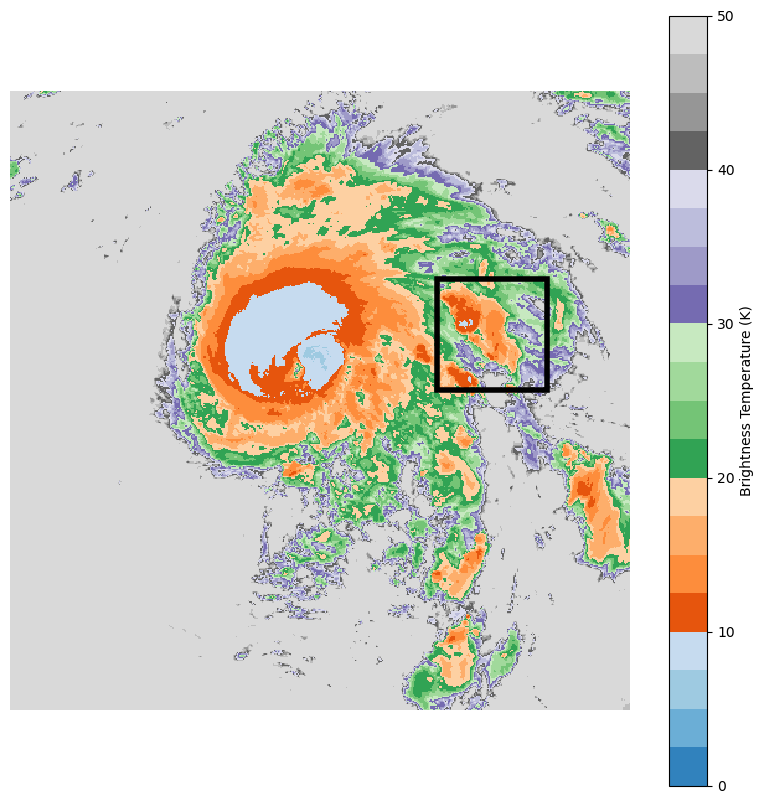

In [59]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=[10, 10])

meso = axes.pcolormesh(sm_x, sm_y, C13, vmin=vmin, vmax=vmax, cmap=plt.get_cmap("tab20c"))
fig.colorbar(meso, label='Brightness Temperature (K)')
zoom_box = patches.Rectangle(lower_left, delta, delta, 
             linewidth=4, edgecolor='black', facecolor='none')
axes.add_patch(zoom_box)
axes.set_aspect('equal')
axes.axis('off')

plt.show()

In [87]:
Xold, Yold = np.meshgrid(sm_x, sm_y)
Xnew, Ynew = np.meshgrid(g16nc.variables['x'][:], g16nc.variables['y'][:]) # Using X and Y from Channel 2 Michael grid image

In [88]:
values = C13.flatten()

dims = (values.shape[0], 2)
points = np.zeros(dims)

points[:, 0] = Xold.flatten()
points[:, 1] = Yold.flatten()

In [89]:
gridOut_nn = scipy.interpolate.griddata(points, values, (Xnew, Ynew), method='nearest')
gridOut_lin = scipy.interpolate.griddata(points, values, (Xnew, Ynew), method='linear')
gridOut_cube = scipy.interpolate.griddata(points, values, (Xnew, Ynew), method='cubic')

In [90]:
gridOut_rebin = np.repeat(np.repeat(C13, 4, axis=1), 4, axis=0)

In [91]:
gridOut = [[gridOut_rebin, gridOut_nn], [gridOut_lin, gridOut_cube]]
labels = [["Re-binning", "Nearest Neighbor"],["Linear", "Cubic"]]
plt.rcParams.update({'font.size': 18, 'figure.figsize': [20, 20]})

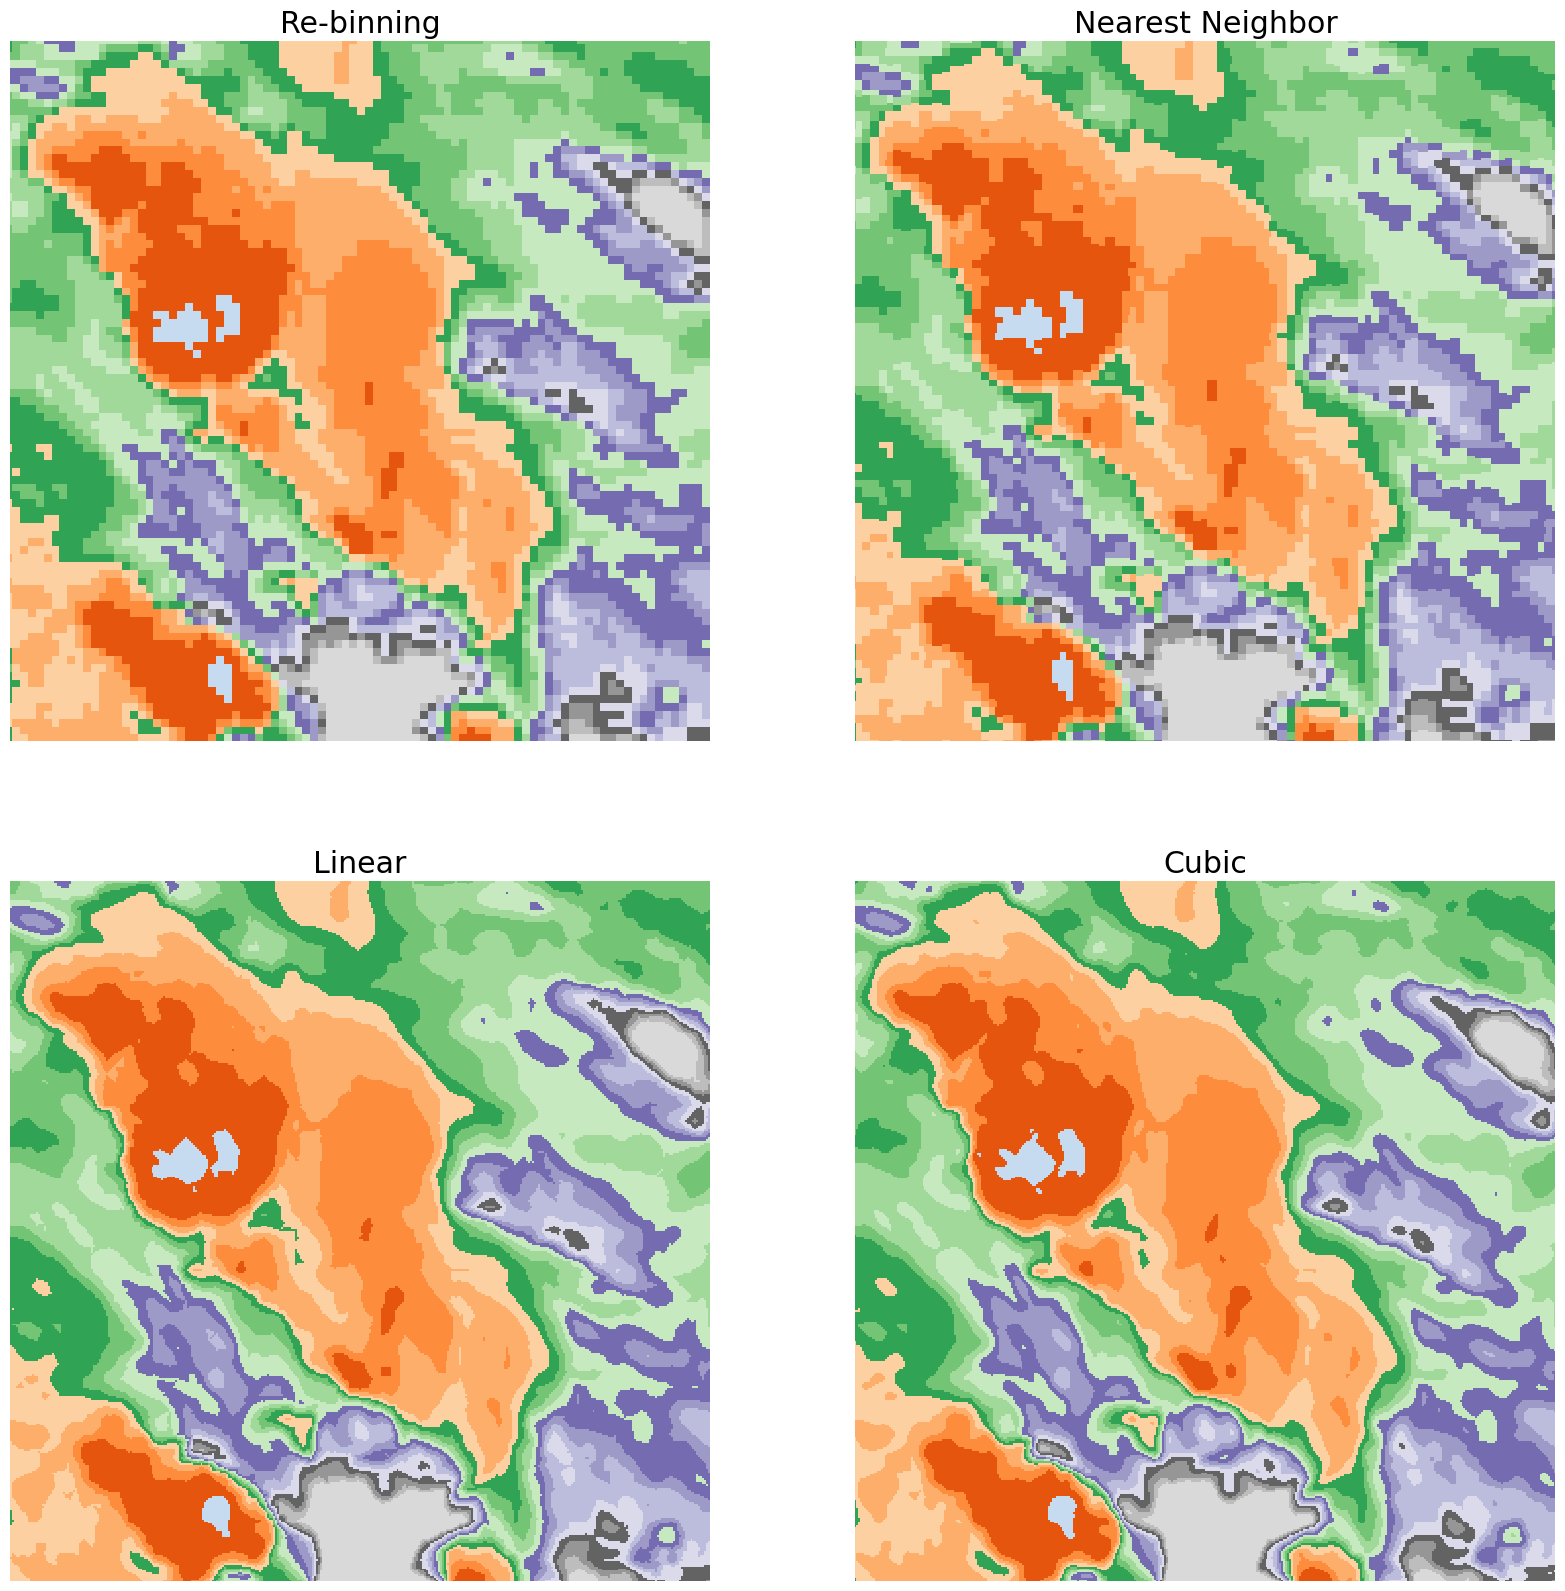

In [97]:
fig, axes = plt.subplots(ncols=2, nrows=2)

cmap=plt.get_cmap("tab20c")

for i, axis in enumerate(axes):
    for j, ax in enumerate(axis):
        ax.set_xlim([xbot, xbot+delta])
        ax.set_ylim([ybot, ybot+delta])
        ax.set_aspect('equal')
        ax.set_title(labels[i][j])
        ax.pcolormesh(Xnew, Ynew, gridOut[i][j], vmin=vmin, vmax=vmax, cmap=cmap)
        ax.axis('off')
plt.show()

In [98]:
from pyresample import geometry
from pyresample.kd_tree import resample_nearest

In [101]:
fname = '../data/aod/JRR-AOD_v1r1_npp_s201808091955538_e201808091957180_c201808092049460_thinned.nc'
file_id_NPP = Dataset(fname)

In [102]:
aod = file_id_NPP.variables['AOD550'][:,:]
lat = file_id_NPP.variables['Latitude'][:,:]
lon = file_id_NPP.variables['Longitude'][:,:]

In [103]:
#Input list of swath points
oldLonLat = geometry.SwathDefinition(lons=lon, lats=lat)

In [113]:
x = np.arange(lon.min(), lon.max(), 0.1)
y = np.arange(lat.min(), lat.max(), 0.1)
newLon, newLat = np.meshgrid(x, y)

In [114]:
newLonLat = geometry.GridDefinition(lons=newLon, lats=newLat)

In [115]:
# Resample the data
newAOD = resample_nearest(oldLonLat, aod, newLonLat, radius_of_influence=5000, fill_value=None)

/Users/justinreid/mambaforge/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/justinreid/mambaforge/lib/python3.10/site-packages/matplotlib/colors.py:719: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


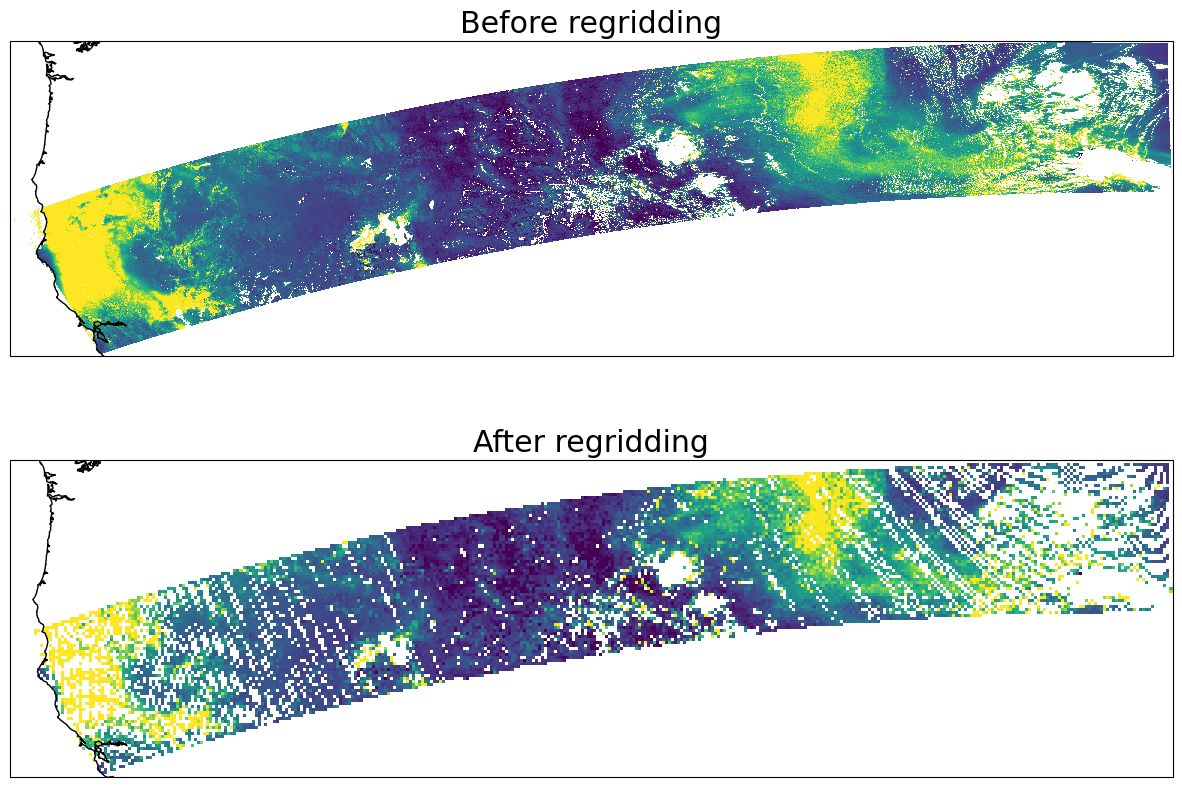

In [116]:
lims = [0, 1]

fig, axes = plt.subplots(nrows=2, figsize=[15, 10], subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.coastlines('10m', color='black')

axes[0].set_title("Before regridding")
axes[0].pcolormesh(lon, lat, aod, vmin=lims[0], vmax=lims[1])

axes[1].set_title("After regridding")
axes[1].pcolormesh(newLon, newLat, newAOD, vmin=lims[0], vmax=lims[1])

plt.show()